### Decision trees & model selection

![img](https://pbs.twimg.com/media/B13n2VVCIAA0hJS.jpg)

In [6]:
import numpy as np

In [7]:
toy_data = np.load('data.npz')
X, y = toy_data['X'], toy_data['y']

print(X.shape, y.shape)

(4505, 2) (4505,)


In [8]:
### again to save training time only 10% of the loaded data is used for training.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)

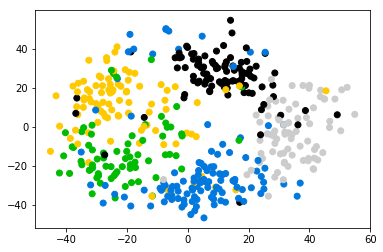

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='nipy_spectral')

# Decision trees out of the box

DecisionTreeClassifier has a number of parameters:
* max_depth : a limit on tree depth (default : no limit)
* min_samples_split : there should be at least this many samples to split further (default : 2)
* min_samples_leaf : there should be at least this many samples on one side of a split to consider it valid (default : 1).
* criterion : 'giny' or 'entropy' - split stuff over this parameter (default : giny)

In [12]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Probably a slightly better way of evaluating quality is by including the mean and std of the metric.

### Plot decision surface

This function takes your classifier and plots it's prediction at each point. Let's see how it works.

(this only works for two dimensions, so it is reasonable to play with the toy dataset before turning to Higgs)

In [13]:
from sklearn.metrics import accuracy_score
def plot_decision_surface(clf, X, y, plot_step = 0.2, cmap='nipy_spectral', figsize=(12,8)):
    """ plot the decision boundary of clf on X and y, visualize training points"""
    plt.figure(figsize=figsize)
    x0_grid, x1_grid = np.meshgrid(np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, plot_step),
                         np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, plot_step))
    y_pred_grid = clf.predict(np.stack([x0_grid.ravel(), x1_grid.ravel()],axis=1)).reshape(x1_grid.shape)
    plt.contourf(x0_grid, x1_grid, y_pred_grid, cmap=cmap, alpha=0.5)  
    y_pred = clf.predict(X)    
    plt.scatter(*X[y_pred==y].T,c = y[y_pred==y],
                marker='.',cmap=cmap,alpha=0.5,label='correct')
    plt.scatter(*X[y_pred!=y].T,c = y[y_pred!=y],
                marker='x',cmap=cmap,s=50,label='errors')
    plt.legend(loc='best')
    print("Accuracy = ",accuracy_score(y, y_pred))
    plt.show()

### Train quality

Accuracy =  1.0


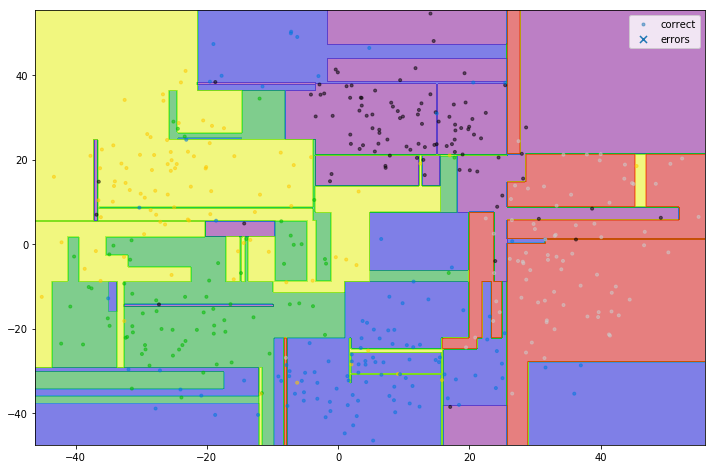

In [14]:
plot_decision_surface(tree, X_train, y_train)

### Test quality


__Before you run it:__ guess what's gonna happen with test accuracy vs train accuracy judging by the train plot?

Accuracy =  0.7213316892725031


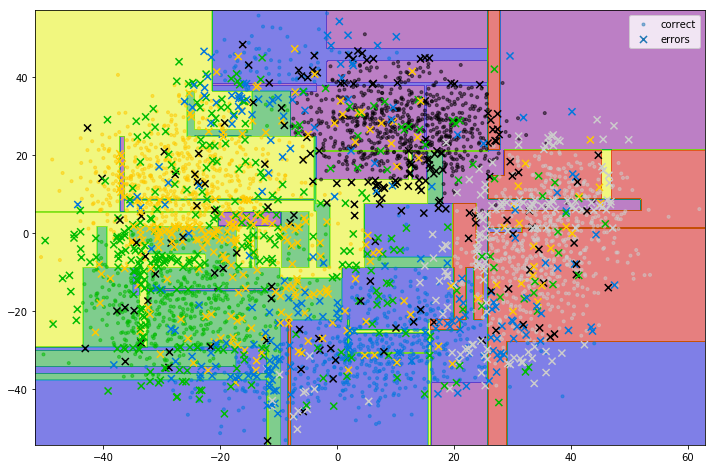

In [15]:
plot_decision_surface(tree,X_test,y_test)

```

```

```

```

```

```

```

```


### We need a better tree!

Try adjusting parameters of DecisionTreeClassifier to improve test accuracy.
 * Accuracy >= 0.72 - not bad for a start
 * Accuracy >= 0.75 - better, but not enough
 * Accuracy >= 0.77 - pretty good
 * Accuracy >= 0.78 - great! (probably the best result for a single tree)
 
Feel free to modify the DecisionTreeClassifier above instead of re-writing everything.

__Note:__ some of the parameters you can tune are under the "Decision trees out of the box" header.

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


### Ensembles

Let's build our own decision tree bagging and see if it works. Implement __`BagOfTrees`__ class below

In [ ]:
class BagOfTrees:
    
    def __init__(self, n_estimators=10, **kwargs):
        self.trees = []
        for i in range(n_estimators):
            self.trees.append(DecisionTreeClassifier(**kwargs))
            
    def fit(self, X, y):
        
        # Fit each of the trees on a random subset of X and y.
        # hint: you can select random subsample of data liek this:
        # >>> ix = np.random.randint(0, len(X), len(X))
        # >>> X_sample, y_sample = X[ix], y[ix]

        <YOUR CODE>
        
    def predict(self, X):
        trees = self.trees
        
        # Compute predictions of each tree and aggregate them into the ensemble prediction
        # Note: you can use tree.predict(X) or tree.predict_proba(X) to get individual predicitons
        
        return <YOURCODE - np.array of prediction indices>
    
# once you thing you're done, see if your code passes asserts below

In [ ]:
model = BagOfTrees(n_estimators=100, min_samples_leaf=5)
model.fit(X_train,y_train)

In [ ]:
print('\n'.join(map(str, model.trees[:2])))

In [ ]:
pred = model.predict(X_test[::100])
print("predictions:", pred)
assert isinstance(pred, np.ndarray), "prediction must be a numpy array"
assert str(pred.dtype).startswith('int'), "prediction dtype must be integer (int32/int64)"
assert pred.ndim == 1, "prediction must be a vector (1-dimensional)"
assert len(pred) == len(X_test[::100]), "must predict exactly one answer for each input (expected length %i, got %i)" % (len(X_test[::100]), len(pred))
assert any(model.trees[0].predict(X_train) != model.trees[1].predict(X_train)), "All trees are the same. Did you forget to train each tree on a random part of data?"

In [ ]:
for i, tree in enumerate(model.trees[:5]):
    print("tree %i individual accuracy = %.5f"%(i+1, accuracy_score(y_test,tree.predict(X_test))))

In [ ]:
print("Ensemble accuracy:", accuracy_score(model.predict(X_test), y_test)) # should be >= 0.79

In [ ]:
plot_decision_surface(model, X_test, y_test)

```

```

```

```

```

```

```

```

```

```

```

```

### Using  existing ensembles : Random Forest

RandomForest combines bagging and random subspaces: each tree uses a fraction of training samples and while split in that tree is chosen among a subset of features. This leads to a slightly better performance.

__Note:__ try re-running your code a few times and see what happens to accuracy.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Task: create and fit a random forest with 100 estimators and at least 5 samples per leaf

model = <YOUR CODE>

<YOUR CODE>

plot_decision_surface(model, X_test, y_test)

In [ ]:
acc = accuracy_score(model.predict(X_test), y_test)
assert acc >= 0.792, "acc is below 0.792. Try changing random forest hyperparameters."

### Using existing ensembles : Gradient Boosting

__Note:__ if you don't have xgboost, use from sklearn.ensemble import GradientBoostingClassifier as XGBClassifier

In [10]:
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
import warnings
warnings.simplefilter("ignore")
from IPython.display import clear_output
from time import sleep

In [ ]:
for n_estimators in range(1,10):
    model = XGBClassifier(max_depth=3, learning_rate=0.5, n_estimators=n_estimators)
    model.fit(X_train, y_train)

    print("n_estimators = ", n_estimators)
    plot_decision_surface(model, X_test, y_test)
    
    

### HIGGS data (100K subsample)

In [8]:
data = np.genfromtxt("/mnt/mlhep2018/datasets/HIGGS.csv", 
                     delimiter=",", dtype=np.float32, max_rows=100000)
X, y = data[:, 1:], data[:, 0]

print(X.shape, y.shape)

(10000, 28) (10000,)


In [11]:
from sklearn.model_selection import cross_val_score

dt_cv = cross_val_score(DecisionTreeClassifier(),
                X, y, 
                cv=4, n_jobs=4, scoring="roc_auc")
print(dt_cv.mean(), dt_cv.std())

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x1035e49c0, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/artonson/.pyenv/versions/3.6.5/lib/python...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/arton.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x1035e49c0, file "/Use...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/artonson/.pyenv/versions/3.6.5/lib/python...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/arton.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(14, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(14, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (14, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=14, events=1)
    117             self.writers.remove(fd)
    118         del self.handlers[fd]
    119 
    120     def _handle_events(self, fd, events):
    121         fileobj, handler_func = self.handlers[fd]
--> 122         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    123 
    124     def start(self):
    125         try:
    126             old_loop = asyncio.get_event_loop()

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import cross_val_sc...oring="roc_auc")\nprint(dt_cv.mean(), dt_cv.std())', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 8, 6, 10, 4, 4, 700068, tzinfo=tzutc()), 'msg_id': '5590b0355b3d45718f859271249fdea7', 'msg_type': 'execute_request', 'session': 'f9700fb8f7e7494c8e57536bac7a7b6a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '5590b0355b3d45718f859271249fdea7', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'f9700fb8f7e7494c8e57536bac7a7b6a']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import cross_val_sc...oring="roc_auc")\nprint(dt_cv.mean(), dt_cv.std())', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 8, 6, 10, 4, 4, 700068, tzinfo=tzutc()), 'msg_id': '5590b0355b3d45718f859271249fdea7', 'msg_type': 'execute_request', 'session': 'f9700fb8f7e7494c8e57536bac7a7b6a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '5590b0355b3d45718f859271249fdea7', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'f9700fb8f7e7494c8e57536bac7a7b6a'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import cross_val_sc...oring="roc_auc")\nprint(dt_cv.mean(), dt_cv.std())', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 8, 6, 10, 4, 4, 700068, tzinfo=tzutc()), 'msg_id': '5590b0355b3d45718f859271249fdea7', 'msg_type': 'execute_request', 'session': 'f9700fb8f7e7494c8e57536bac7a7b6a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '5590b0355b3d45718f859271249fdea7', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.model_selection import cross_val_sc...oring="roc_auc")\nprint(dt_cv.mean(), dt_cv.std())', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.model_selection import cross_val_sc...oring="roc_auc")\nprint(dt_cv.mean(), dt_cv.std())'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.model_selection import cross_val_sc...oring="roc_auc")\nprint(dt_cv.mean(), dt_cv.std())',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.model_selection import cross_val_sc...oring="roc_auc")\nprint(dt_cv.mean(), dt_cv.std())',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.model_selection import cross_val_sc...oring="roc_auc")\nprint(dt_cv.mean(), dt_cv.std())', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'from sklearn.model_selection import cross_val_sc...oring="roc_auc")\nprint(dt_cv.mean(), dt_cv.std())'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.model_selection import cross_val_sc...oring="roc_auc")\nprint(dt_cv.mean(), dt_cv.std())', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-11-58cadbb34fb9>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 10c549198, execution_...rue silent=False shell_futures=True> result=None>)
   2896             raise ValueError("Interactivity was %r" % interactivity)
   2897         try:
   2898             for i, node in enumerate(to_run_exec):
   2899                 mod = ast.Module([node])
   2900                 code = compiler(mod, cell_name, "exec")
-> 2901                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x111d235d0, file "<ipython-input-11-58cadbb34fb9>", line 3>
        result = <ExecutionResult object at 10c549198, execution_...rue silent=False shell_futures=True> result=None>
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x111d235d0, file "<ipython-input-11-58cadbb34fb9>", line 3>, result=<ExecutionResult object at 10c549198, execution_...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x111d235d0, file "<ipython-input-11-58cadbb34fb9>", line 3>
        self.user_global_ns = {'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'In': ['', "toy_data = np.load('data.npz')", 'import numpy as np', "toy_data = np.load('data.npz')", "toy_data = np.load('data.npz')\nX, y = toy_data['X'], toy_data['y']", "toy_data = np.load('data.npz')\nX, y = toy_data['X'], toy_data['y']\n\nprint(X.shape, y.shape)", 'import numpy as np', "toy_data = np.load('data.npz')\nX, y = toy_data['X'], toy_data['y']\n\nprint(X.shape, y.shape)", '### again to save training time only 10% of the ...n, y_test = train_test_split(X, y, test_size=0.9)', "import matplotlib.pyplot as plt\nget_ipython().ru...:,0],X_train[:,1],c=y_train,cmap='nipy_spectral')", 'from sklearn.tree import DecisionTreeClassifier\n...ecisionTreeClassifier()\ntree.fit(X_train,y_train)', 'from sklearn.model_selection import cross_val_sc...oring="roc_auc")\nprint(dt_cv.mean(), dt_cv.std())'], 'Out': {9: <matplotlib.collections.PathCollection object>, 10: DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best')}, 'X': array([[  8.50782461,  25.65625575],
       [  0....91404747],
       [ 20.51828541,  28.77164202]]), 'X_test': array([[-27.64812817, -38.35959307],
       [  3....42002674],
       [-21.86501449,  22.55750319]]), 'X_train': array([[ 1.40607379e+01,  3.54922534e+01],
     ...+01],
       [ 4.50108434e+01,  1.42438402e+01]]), '_': DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), '_10': DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), '_9': <matplotlib.collections.PathCollection object>, '__': <matplotlib.collections.PathCollection object>, ...}
        self.user_ns = {'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'In': ['', "toy_data = np.load('data.npz')", 'import numpy as np', "toy_data = np.load('data.npz')", "toy_data = np.load('data.npz')\nX, y = toy_data['X'], toy_data['y']", "toy_data = np.load('data.npz')\nX, y = toy_data['X'], toy_data['y']\n\nprint(X.shape, y.shape)", 'import numpy as np', "toy_data = np.load('data.npz')\nX, y = toy_data['X'], toy_data['y']\n\nprint(X.shape, y.shape)", '### again to save training time only 10% of the ...n, y_test = train_test_split(X, y, test_size=0.9)', "import matplotlib.pyplot as plt\nget_ipython().ru...:,0],X_train[:,1],c=y_train,cmap='nipy_spectral')", 'from sklearn.tree import DecisionTreeClassifier\n...ecisionTreeClassifier()\ntree.fit(X_train,y_train)', 'from sklearn.model_selection import cross_val_sc...oring="roc_auc")\nprint(dt_cv.mean(), dt_cv.std())'], 'Out': {9: <matplotlib.collections.PathCollection object>, 10: DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best')}, 'X': array([[  8.50782461,  25.65625575],
       [  0....91404747],
       [ 20.51828541,  28.77164202]]), 'X_test': array([[-27.64812817, -38.35959307],
       [  3....42002674],
       [-21.86501449,  22.55750319]]), 'X_train': array([[ 1.40607379e+01,  3.54922534e+01],
     ...+01],
       [ 4.50108434e+01,  1.42438402e+01]]), '_': DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), '_10': DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), '_9': <matplotlib.collections.PathCollection object>, '__': <matplotlib.collections.PathCollection object>, ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
/Users/artonson/repos/mlhep2018/day1-Mon/<ipython-input-11-58cadbb34fb9> in <module>()
      1 from sklearn.model_selection import cross_val_score
      2 
      3 dt_cv = cross_val_score(DecisionTreeClassifier(),
      4                 X, y, 
----> 5                 cv=4, n_jobs=4, scoring="roc_auc")
      6 print(dt_cv.mean(), dt_cv.std())

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_val_score(estimator=DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), X=array([[  8.50782461,  25.65625575],
       [  0....91404747],
       [ 20.51828541,  28.77164202]]), y=array([0, 1, 3, ..., 4, 4, 0]), groups=None, scoring='roc_auc', cv=4, n_jobs=4, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    337     cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
    338                                 scoring={'score': scorer}, cv=cv,
    339                                 return_train_score=False,
    340                                 n_jobs=n_jobs, verbose=verbose,
    341                                 fit_params=fit_params,
--> 342                                 pre_dispatch=pre_dispatch)
        pre_dispatch = '2*n_jobs'
    343     return cv_results['test_score']
    344 
    345 
    346 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_validate(estimator=DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), X=array([[  8.50782461,  25.65625575],
       [  0....91404747],
       [ 20.51828541,  28.77164202]]), y=array([0, 1, 3, ..., 4, 4, 0]), groups=None, scoring={'score': make_scorer(roc_auc_score, needs_threshold=True)}, cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False), n_jobs=4, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False)
    201     scores = parallel(
    202         delayed(_fit_and_score)(
    203             clone(estimator), X, y, scorers, train, test, verbose, None,
    204             fit_params, return_train_score=return_train_score,
    205             return_times=True)
--> 206         for train, test in cv.split(X, y, groups))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=4, random_state=None, shuffle=False)>
        X = array([[  8.50782461,  25.65625575],
       [  0....91404747],
       [ 20.51828541,  28.77164202]])
        y = array([0, 1, 3, ..., 4, 4, 0])
        groups = None
    207 
    208     if return_train_score:
    209         train_scores, test_scores, fit_times, score_times = zip(*scores)
    210         train_scores = _aggregate_score_dicts(train_scores)

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object cross_validate.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Aug  6 11:04:04 2018
PID: 24928Python 3.6.5: /Users/artonson/.pyenv/versions/3.6.5/bin/python3.6
...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), array([[  8.50782461,  25.65625575],
       [  0....91404747],
       [ 20.51828541,  28.77164202]]), array([0, 1, 3, ..., 4, 4, 0]), {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([1114, 1116, 1117, ..., 4502, 4503, 4504]), array([   0,    1,    2, ..., 1147, 1151, 1164]), 0, None, None), {'return_times': True, 'return_train_score': False})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), array([[  8.50782461,  25.65625575],
       [  0....91404747],
       [ 20.51828541,  28.77164202]]), array([0, 1, 3, ..., 4, 4, 0]), {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([1114, 1116, 1117, ..., 4502, 4503, 4504]), array([   0,    1,    2, ..., 1147, 1151, 1164]), 0, None, None)
        kwargs = {'return_times': True, 'return_train_score': False}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), X=array([[  8.50782461,  25.65625575],
       [  0....91404747],
       [ 20.51828541,  28.77164202]]), y=array([0, 1, 3, ..., 4, 4, 0]), scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([1114, 1116, 1117, ..., 4502, 4503, 4504]), test=array([   0,    1,    2, ..., 1147, 1151, 1164]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=True, error_score='raise')
    483                              " make sure that it has been spelled correctly.)")
    484 
    485     else:
    486         fit_time = time.time() - start_time
    487         # _score will return dict if is_multimetric is True
--> 488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best')
        X_test = array([[  8.50782461,  25.65625575],
       [  0....07037253],
       [-15.3465214 ,  33.18463668]])
        y_test = array([0, 1, 3, ..., 3, 3, 3])
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
        is_multimetric = True
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
    492                                   is_multimetric)

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _score(estimator=DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), X_test=array([[  8.50782461,  25.65625575],
       [  0....07037253],
       [-15.3465214 ,  33.18463668]]), y_test=array([0, 1, 3, ..., 3, 3, 3]), scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best')
        X_test = array([[  8.50782461,  25.65625575],
       [  0....07037253],
       [-15.3465214 ,  33.18463668]])
        y_test = array([0, 1, 3, ..., 3, 3, 3])
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _multimetric_score(estimator=DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), X_test=array([[  8.50782461,  25.65625575],
       [  0....07037253],
       [-15.3465214 ,  33.18463668]]), y_test=array([0, 1, 3, ..., 3, 3, 3]), scorers={'score': make_scorer(roc_auc_score, needs_threshold=True)})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
        estimator = DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best')
        X_test = array([[  8.50782461,  25.65625575],
       [  0....07037253],
       [-15.3465214 ,  33.18463668]])
        y_test = array([0, 1, 3, ..., 3, 3, 3])
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
/Users/artonson/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(roc_auc_score, needs_threshold=True), clf=DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), X=array([[  8.50782461,  25.65625575],
       [  0....07037253],
       [-15.3465214 ,  33.18463668]]), y=array([0, 1, 3, ..., 3, 3, 3]), sample_weight=None)
    176         """
    177         super(_ThresholdScorer, self).__call__(clf, X, y,
    178                                                sample_weight=sample_weight)
    179         y_type = type_of_target(y)
    180         if y_type not in ("binary", "multilabel-indicator"):
--> 181             raise ValueError("{0} format is not supported".format(y_type))
        y_type = 'multiclass'
    182 
    183         if is_regressor(clf):
    184             y_pred = clf.predict(X)
    185         else:

ValueError: multiclass format is not supported
___________________________________________________________________________

### Grid search

__Bonus Quest:__ Find optimal parameters for GradientBoostingClassifier using grid search.

This time please use a special validation set (i.e. don't make decisions based on X_test, y_test).

You can implement a loop that searches over max_depth and learning_rate for a __fixed n_estmators=100__.

In [ ]:

< YOUR CODE HERE >


In [ ]:
final_model = <your_code>
plot_decision_surface(final_model,X_test,y_test)

```

```

```

```

```

```

```

```

```

```

```

```

```

```

### Automatic ML: model selection

While grid search is reasonably good for parameter optimization, it oftentimes spends a lot of times exploring hopeless regions. There are other approaches to finding optimal model that can result in drastically smaller cpu time.

The first approach is __bayesian optimization__, whos main idea is to model probability density function of a score (e.g. accuracy) at every point and explore points that are most likely to give optimal solution. The "wilingness to try this point" is called the acquisition function.

Here's an example:
![gp](https://cloud.google.com/blog/big-data/2017/08/images/150162099779222/hyperparameter-31-c.png)


The most popular bayesian optimization methods are __gaussian process optimization(GP)__ and __tree-structured parzen estimators (TPE)__, differning mainly in the way they estimate the distributions. 

This time we're gonna see TPE in action using the [modelgym](https://github.com/yandexdataschool/modelgym) package.

_warning: the package is still in early development, some things may suddenly break down_

In [ ]:
!pip install https://github.com/yandexdataschool/modelgym/archive/master.zip > modelgym.log
!pip install lightgbm > lightgbm.log

In [ ]:
from modelgym.models import CtBClassifier # CatBoost gradient boosting
from modelgym.utils import XYCDataset, ModelSpace
from modelgym.metrics import Accuracy

In [ ]:
from modelgym.trainers import TpeTrainer

trainer = TpeTrainer([ModelSpace(CtBClassifier, {'iterations':25})]) #you can add more models here...

trainer.crossval_optimize_params(Accuracy(), XYCDataset(X_train, y_train), cv=3)

In [ ]:
trainer.get_best_results()

An alternative approach here is __stochastic optimization__. If bayesian optimization is like a scalpel that cuts precisely where it should, stochastic optimization is a shotgun that shoots a bunch of pellets and sees which of them are most successful.

We're gonna see this in action with the help of [tpot](https://github.com/EpistasisLab/tpot/) - a library for hyperparameter optimization via genetic programming.

In [ ]:
!pip install tpot > tpot.log

In [ ]:
from tpot import TPOTClassifier

trainer = TPOTClassifier(population_size=50, generations=10, # genetic algorithm params
                         cv=3,                               # 3-fold cross-validation
                         n_jobs=4,                           # parallel processes
                         max_eval_time_mins = 0.5            # model should train in under 30 seconds
                         verbosity=2,
                        )


In [ ]:
trainer.fit(X_train, y_train)

In [ ]:
best_model = trainer.fitted_pipeline_
print("TPOT test accuracy =", accuracy_score(y_test, best_model.predict(X_test)))